# Pokémon - data catch 'em all

In this mini-project we use a Pokémon dataset (Gen 1–9) to **argue, in a very scientific and totally unbiased way**, that early generations were better.

In [114]:
import kagglehub
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2

## Load the dataset and inspect columns

If available, load the CSV from disk or download from Kaggle.

In [115]:
data_dir = os.path.join("data", "pokemon-dataset-gen-1-9")

if os.path.exists(data_dir):
    print("Dataset already exists. Skipping download.")
else:
    cache_path = kagglehub.dataset_download("omkarbhujbalrao/pokemon-dataset-gen-1-9")
    os.makedirs(os.path.dirname(data_dir), exist_ok=True)
    shutil.move(cache_path, data_dir)

data = pd.read_csv(os.path.join(data_dir, "pokedataset (1).csv"))
df = data.copy()
display(df.head())
print("Columns:")
print(list(df.columns))
print(list(df['Type_1'].unique()))

Dataset already exists. Skipping download.


,id,Name,Height(m),Weight{kg},HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,...,Egg_Group_1,Egg_Group_2,Generation,Capture_Rate,Base_Happiness,Is_Baby,Egg_Cycles,Past_Type,Is_Pseudo_Legendary,Total_Stats
0,1,Bulbasaur,0.7,6.9,45,49,49,65,65,45,...,Monster,Plant,Gen-1,45,70,False,20,NaN,False,318
1,2,Ivysaur,1.0,13.0,60,62,63,80,80,60,...,Monster,Plant,Gen-1,45,70,False,20,NaN,False,405
2,3,Venusaur,2.0,100.0,80,82,83,100,100,80,...,Monster,Plant,Gen-1,45,70,False,20,NaN,False,525
3,4,Charmander,0.6,8.5,39,52,43,60,50,65,...,Monster,Dragon,Gen-1,45,70,False,20,NaN,False,309
4,5,Charmeleon,1.1,19.0,58,64,58,80,65,80,...,Monster,Dragon,Gen-1,45,70,False,20,NaN,False,405


Columns:
['id', 'Name', 'Height(m)', 'Weight{kg}', 'HP', 'Attack', 'Defense', 'Sp.Atk', 'Sp.Def', 'Speed', 'Type_1', 'Type_2', 'Is_Legendary', 'Is_Mythical', 'Egg_Group_1', 'Egg_Group_2', 'Generation', 'Capture_Rate', 'Base_Happiness', 'Is_Baby', 'Egg_Cycles', 'Past_Type', 'Is_Pseudo_Legendary', 'Total_Stats']
['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Dragon', 'Dark', 'Steel', 'Flying']


## Total stats and their variation

To compare the overall *balance* of Pokémon across generations, we compute a **Total Stat** (HP + Attack + Defense + Sp.Atk + Sp.Def + Speed). Then we check the **mean** and **standard deviation** per generation.

If older generations really were more “balanced”, they should have *lower* averages and *smaller* spreads.


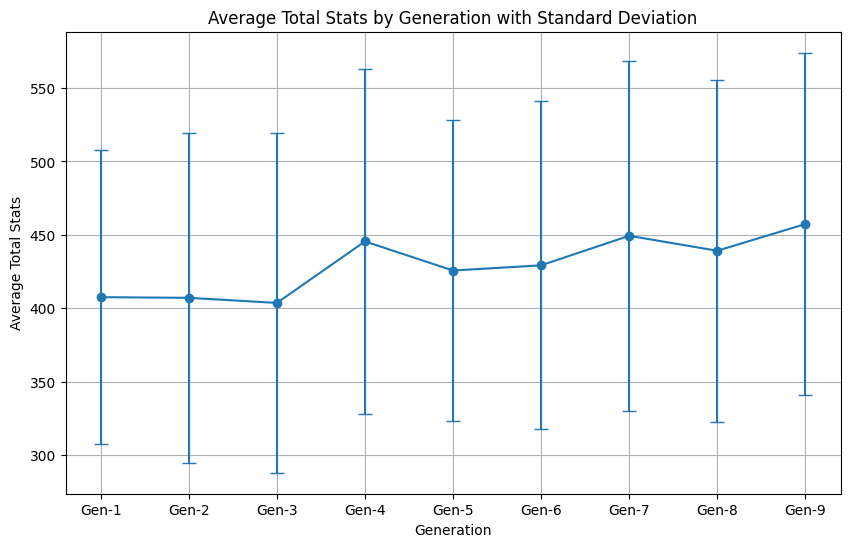

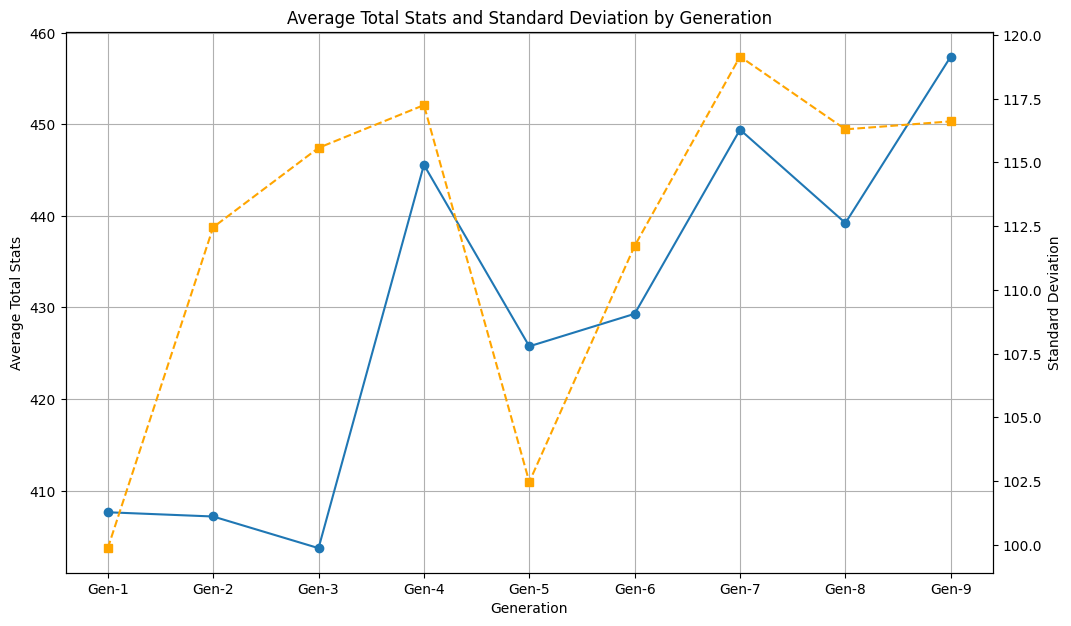

In [116]:
df['Total_Stat'] = df['HP'] + df['Attack'] + df['Defense'] + df['Sp.Atk'] + df['Sp.Def'] + df['Speed']

group = df.groupby("Generation")["Total_Stat"]
mean_stats = group.mean()
err_stats = group.std()

plt.figure(figsize=(10, 6))
plt.errorbar(mean_stats.index, mean_stats.values, yerr=err_stats.values, fmt='o-', capsize=5)
plt.title('Average Total Stats by Generation with Standard Deviation')
plt.xlabel('Generation')
plt.ylabel('Average Total Stats')
plt.xticks(sorted(df['Generation'].unique()))
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.tight_layout()
ax2 = ax1.twinx()
ax1.plot(mean_stats.index, mean_stats.values, 'o-')
ax2.plot(err_stats.index, err_stats.values, 's--', color='orange')
ax1.set_title('Average Total Stats and Standard Deviation by Generation')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Average Total Stats')
ax2.set_ylabel('Standard Deviation')
ax1.set_xticks(sorted(df['Generation'].unique()))
ax1.grid()
plt.show()

## Special Pokémon ratio

We classify "special" Pokémon as **Legendary or Mythical**. Then we compute, per generation, what fraction of the Pokédex they make up.

If newer generations rely more on “sparkly ultra-mega-rare-super” Pokémon, this ratio will grow over time.


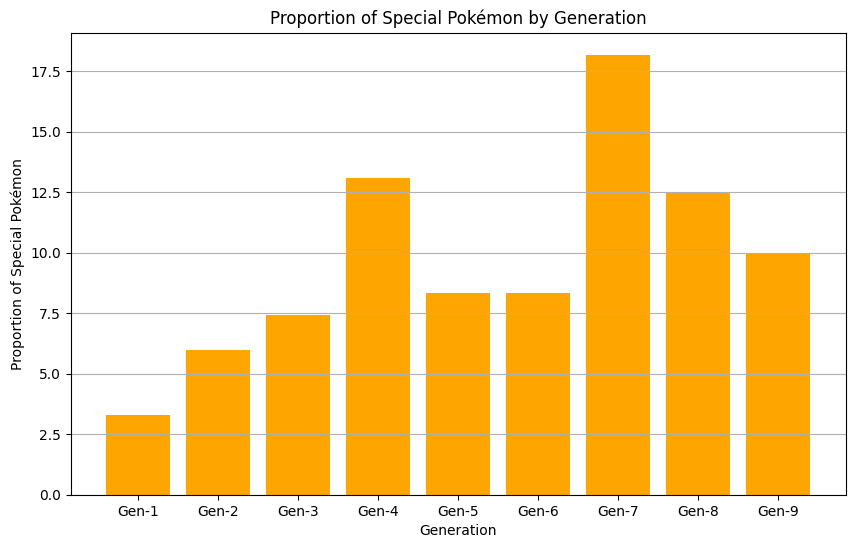

In [117]:
df['Is_Special'] = df['Is_Legendary'] | df['Is_Mythical']

group = df.groupby("Generation")["Is_Special"]
special_count = group.mean()

plt.figure(figsize=(10, 6))
plt.bar(special_count.index, special_count.values * 100, color='orange')
plt.title('Proportion of Special Pokémon by Generation')
plt.xlabel('Generation')
plt.ylabel('Proportion of Special Pokémon')
plt.xticks(sorted(df['Generation'].unique()))
plt.grid(axis='y')
plt.show()

## Shannon entropy of Pokémon types

To track how type diversity changes across generations, we compute the **Shannon entropy** of Pokémon types. A Pokémon contributes to a type if either its first or second type matches.

High entropy means lots of different types coexisting—like a vibrant fantasy ecosystem. Low entropy suggests a simpler, more uniform habitat, closer to real-world regions where one or two species tend to dominate the whole food chain.

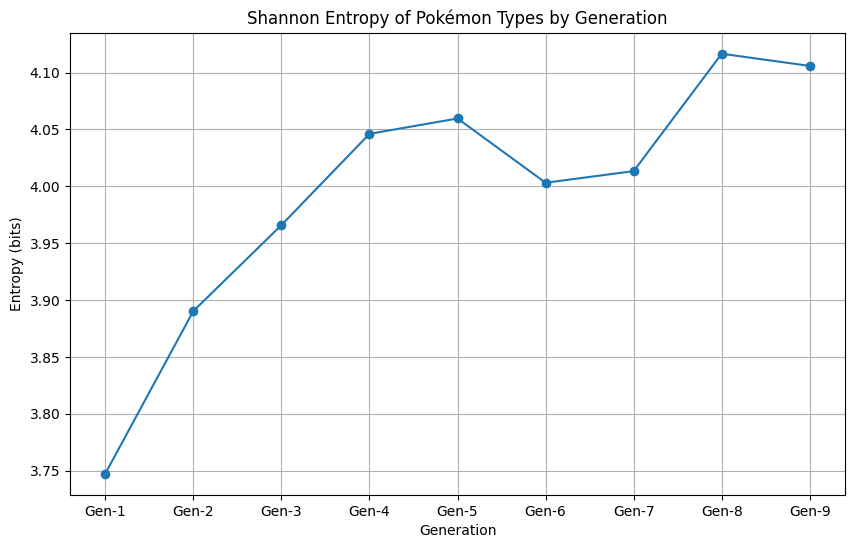

In [118]:
def shannon_entropy(counts):
    total = counts.sum()
    p = counts / total
    return -np.sum([pi * log2(pi) for pi in p if pi > 0])

# Build an expanded type list
df['All_Types'] = df.apply(
    lambda row: {row['Type_1']} | ({row['Type_2']} if isinstance(row['Type_2'], str) else set()),
    axis=1
)

# Compute entropy per generation
entropy_by_gen = {}

for gen, group_df in df.groupby("Generation"):
    # Flatten the multiset of types
    all_types = []
    for typeset in group_df['All_Types']:
        all_types.extend(typeset)
    counts = pd.Series(all_types).value_counts()
    entropy_by_gen[gen] = shannon_entropy(counts)

entropy_by_gen = pd.Series(entropy_by_gen).sort_index()

plt.figure(figsize=(10, 6))
plt.plot(entropy_by_gen.index, entropy_by_gen.values, 'o-')
plt.title('Shannon Entropy of Pokémon Types by Generation')
plt.xlabel('Generation')
plt.ylabel('Entropy (bits)')
plt.grid()
plt.show()

## Magical vs. Regular type ratio

To test whether Pokémon design drifted from “grounded fantasy creatures” toward increasingly mystical beings, we examine the proportion of **magical** types (Fire, Electric, Fairy, Psychic, Ghost and Dragon) vs. all others.

A Pokémon is considered magical if *either* of its types belongs to this group.

If recent generations rely more heavily on mystical aesthetics, this ratio should steadily increase.

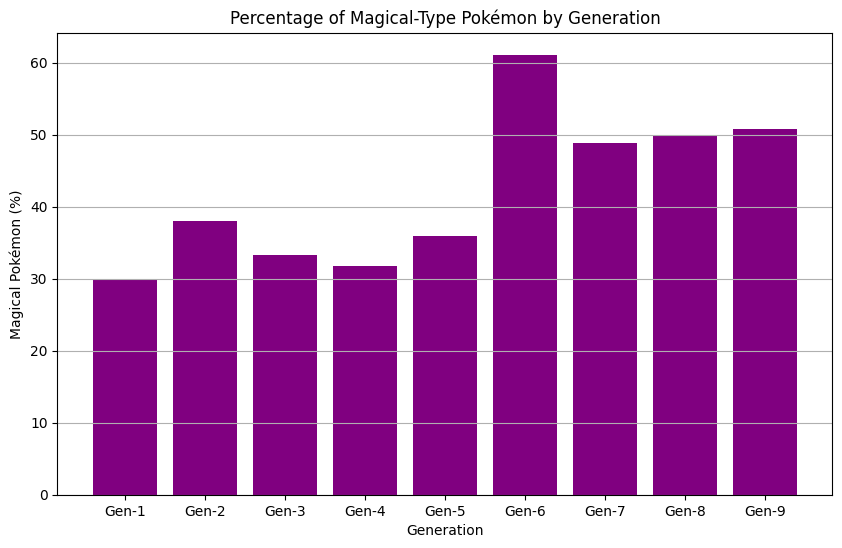

In [119]:
magical_types = ['Fire', 'Electric', 'Fairy', 'Psychic', 'Ghost', 'Dragon']
df['Is_Magical'] = df['Type_1'].isin(magical_types) | df['Type_2'].isin(magical_types)

magical_ratio = df.groupby("Generation")['Is_Magical'].mean()

plt.figure(figsize=(10, 6))
plt.bar(magical_ratio.index, magical_ratio.values * 100, color='purple')
plt.title('Percentage of Magical-Type Pokémon by Generation')
plt.xlabel('Generation')
plt.ylabel('Magical Pokémon (%)')
plt.xticks(sorted(df['Generation'].unique()))
plt.grid(axis='y')
plt.show()